In [43]:
%matplotlib inline
import bt
import matplotlib.pyplot as plt

In [44]:
data = bt.get("tlt", start="2015-01-01", end="2022-06-30")

In [45]:
def build_strategy(weights):
    return bt.Strategy(
        'wd',
        [bt.algos.SelectAll(),
         bt.algos.WeighTarget(weights),
         bt.algos.Rebalance()]
    )

In [46]:
def build_backtest(strategy, df, initial_capital, commission_model):
    return bt.Backtest(
        strategy,
        df,
        initial_capital=initial_capital,
        commissions=commission_model,

    )

In [47]:
def commission_model(q, p):

    # p is price, q is quantity
    val = abs(q * p)
    if val > 2000:
        return 8.6
    if val > 1000:
        return 4.3
    if val > 100:
        return 1.5
    return 1.0

In [48]:
def add_dom(df):

    # add the day of month and return
    added = df.copy()
    added["day_of_month"] = df.index.day
    return added

In [49]:
def add_weights(df, symbol):

    # start with no position within the month
    strategy = df[[symbol]].copy()

    # start with no position within the month
    strategy.loc[:] = 0

    # short within the first week of the month
    strategy.loc[df.day_of_month <= 7] = -1

    # long during the last week of the month
    strategy.loc[df.day_of_month >= 23] = 1

    return strategy

In [50]:
initial_capital = 10_000

In [51]:
# add the day of month
data_with_dom = add_dom(data)

# get the portfolio weights
weights = add_weights(data_with_dom, 'tlt')

# build the bt strategy
strategy = build_strategy(weights)

#build the backtest
backtest = build_backtest(strategy, data, initial_capital, commission_model)

#run the backtest
first_res = bt.run(backtest)

In [52]:
first_res.display()

Stat                 wd
-------------------  ----------
Start                2015-01-01
End                  2022-06-30
Risk-free rate       0.00%

Total Return         24.91%
Daily Sharpe         0.35
Daily Sortino        0.55
CAGR                 3.01%
Max Drawdown         -20.89%
Calmar Ratio         0.14

MTD                  2.11%
3m                   6.89%
6m                   13.62%
YTD                  13.40%
1Y                   21.67%
3Y (ann.)            9.96%
5Y (ann.)            5.39%
10Y (ann.)           -
Since Incep. (ann.)  3.01%

Daily Sharpe         0.35
Daily Sortino        0.55
Daily Mean (ann.)    3.46%
Daily Vol (ann.)     9.85%
Daily Skew           0.01
Daily Kurt           6.49
Best Day             3.45%
Worst Day            -5.23%

Monthly Sharpe       0.36
Monthly Sortino      0.57
Monthly Mean (ann.)  3.39%
Monthly Vol (ann.)   9.34%
Monthly Skew         -1.02
Monthly Kurt         3.83
Best Month           5.65%
Worst Month          -12.09%

Yearly Sharpe   

<AxesSubplot:title={'center':'Equity Progression'}>

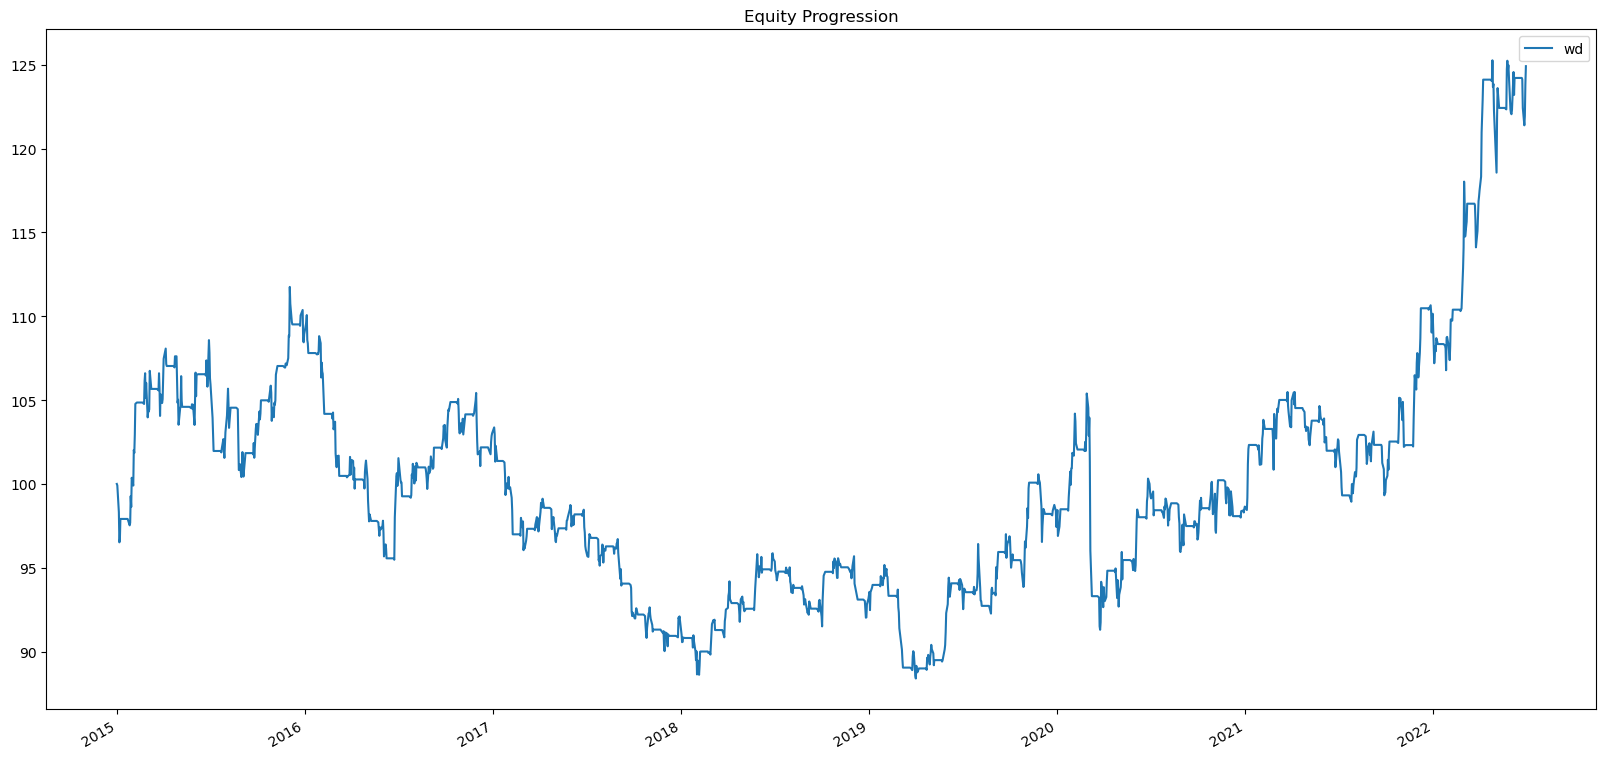

In [53]:
first_res.plot(figsize=(20, 10))

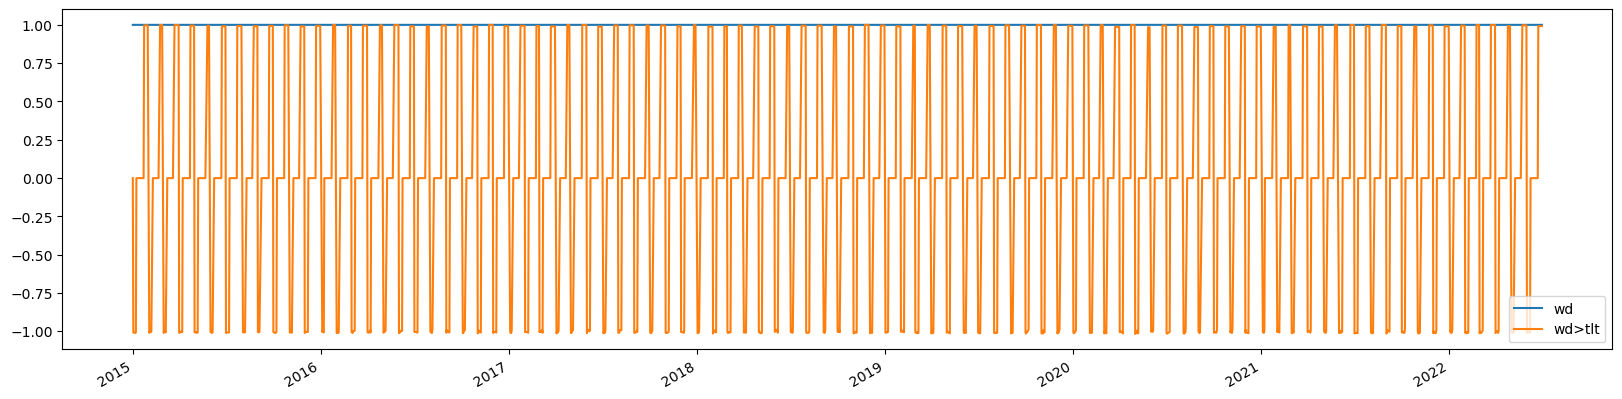

In [54]:
first_res.plot_weights('wd', figsize=(20, 5))

In [55]:
def shuffle_prices(df):

    # randomly shuffle the prices without replacement
    shuffled = df.sample(frac=1)

    # reset the index
    shuffled.index = df.index

    return shuffled

In [56]:
runs = 1000
initial_sharpe = first_res['wd'].daily_sharpe
sharpes = []

In [57]:
for run in range(0, runs):

    # shuffle the prices
    shuffled = shuffle_prices(data)

    # add the day of month
    shuffled_with_dom = add_dom(shuffled)

    # add the weights
    weights = add_weights(shuffled_with_dom, 'tlt')

    # build the strategy
    strategy = build_strategy(weights)

    # build the backtest
    backtest = build_backtest(strategy, shuffled_with_dom, initial_capital, commission_model)

    # run the backtest
    res = bt.run(backtest)

    # accumulate sharpe ratios
    sharpe = res['wd'].daily_sharpe
    sharpes.append(sharpe)

Exception: The difference between what we have raised with q and the amount we are trying to raise has gotten bigger since last iteration! full_outlay should always be approaching amount! There may be a case where the commission fn is not smooth

In [ ]:
N = sum(i > initial_sharpe for i in sharpes)
p_value = N / runs